<a href="https://colab.research.google.com/github/kalingasajja/ML-learn/blob/main/3_experiment_2_bow_tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 13.1 MB/s eta 0:00:00


In [42]:
import mlflow
mlflow.set_tracking_uri("https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/")



In [39]:
# Create a new experiment
mlflow.set_experiment("Exp2 - Bow vs Tfidf")

<Experiment: artifact_location='file:C:/Users/kalin/mlflow_local_project/mlruns/2', creation_time=1750363769307, experiment_id='2', last_update_time=1750363769307, lifecycle_stage='active', name='Exp2 - Bow vs Tfidf', tags={}>

In [25]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_predict,StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df = pd.read_csv("/content/reddit_preprocessing.csv").dropna(subset=['clean_comment'])
df.shape

(36793, 2)

In [43]:
def run_experiment(vectorizer_type,ngram_range,vectorizer_max_features,vectorizer_name):

  # vectorization
  if vectorizer_type == "BoW":
    vectorizer = CountVectorizer(ngram_range=ngram_range,max_features=vectorizer_max_features)
  else:
    vectorizer = TfidfVectorizer(ngram_range=ngram_range,max_features=vectorizer_max_features)

  # Split data *after* cleaning
  X_train,X_test,y_train,y_test = train_test_split(df['clean_comment'],df['category'],test_size=0.2,random_state=42)
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)

  if mlflow.active_run():
    mlflow.end_run()

  with mlflow.start_run(nested=True) as run :
    # set tags for the experiment and run
    mlflow.set_tag("mlflow.runName",f"{vectorizer_name}_{ngram_range}_RandomForest")
    mlflow.set_tag("experiment_type","feature_engineering")
    mlflow.set_tag("model_type","RandomForestClassifier")
    params = {
      "vectorizer_type": vectorizer_type, # Note: This parameter is hardcoded, consider making it dynamic based on vectorizer_type input
      "vectorizer_max_features": vectorizer.max_features,
      "ngram__range": ngram_range,
      "n_estimators": 200,
      "max_depth": 15
  }
  mlflow.log_params(params)

  # Initialize and train the model
  # Initialize the model
  model = RandomForestClassifier(n_estimators=params["n_estimators"],max_depth=params["max_depth"],random_state=42)
  model.fit(X_train,y_train)

  #Make predictions on the test set
  y_pred = model.predict(X_test)

  # Log metrics for each class and accuracy
  accuracy = accuracy_score(y_test,y_pred)
  mlflow.log_metric("accuracy",accuracy)
  print(f"accuracy: {accuracy}")

  classification_rep = classification_report(y_test,y_pred,output_dict=True)

  for label , metrics in classification_rep.items():
    if isinstance(metrics,dict):
       # for precision , recall , f1-score, etc.,
       for metric,value in metrics.items():

         mlflow.log_metric(f"{label}_{metric}",value)

  # confusion Matrix plot
  conf_matrix = confusion_matrix(y_test,y_pred)
  plt.figure(figsize=(8,6))
  sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="Blues")
  plt.title(f"Confusion Matrix: {vectorizer_name}, { ngram_range}")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")

  # Save the plot to a temporary file name
  plot_filename = f"/confusion_matrix_{vectorizer_name}_{ngram_range}.png"
  plt.savefig(plot_filename)
  mlflow.log_artifact(plot_filename)

  # Log the Random Forest Model
  mlflow.sklearn.log_model(model,f"random_forest_model_{vectorizer_name}_{ngram_range}")


🏃 View run BoW_(1, 1)_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2/runs/305956b80d45401cbeb0935efeebe48b
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2
accuracy: 0.6371789645332246


2025/06/19 21:17:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:17:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run overjoyed-stoat-706 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2/runs/54ad2183587e4497a2d7f2411273f18f
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2
🏃 View run TF-IDF_(1, 1)_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2/runs/e71c70674c2142b7a39ae3b3e8824205
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2
accuracy: 0.6381301807310776


2025/06/19 21:17:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:18:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run sincere-hound-254 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2/runs/2954a0a8004741068b55dc44a848b678
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2
🏃 View run BoW_(1, 2)_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2/runs/fbc8e8e2732c48059ade87bfee559f64
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2
accuracy: 0.6398967250985188


2025/06/19 21:18:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:18:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run intrigued-eel-567 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2/runs/6ac78ebed9f849d6b9fb4758ee184278
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2
🏃 View run TF-IDF_(1, 2)_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2/runs/4a48b13d541e4deab0b5ee000e5eb21f
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2
accuracy: 0.6377225166462834


2025/06/19 21:19:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:19:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run gaudy-skink-660 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2/runs/8e4b69a99ea9403caf5f13b4f4845773
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2
🏃 View run BoW_(1, 3)_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2/runs/8dce279adcbc4f6999788c3597590d60
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2
accuracy: 0.6385378448158717


2025/06/19 21:20:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:20:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run stylish-stag-940 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2/runs/26647bfcc3f74fb181b7ff49aa4f87a2
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2
🏃 View run TF-IDF_(1, 3)_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2/runs/326df837cf2e45b6ab229c5ff840be2c
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/2
accuracy: 0.6378584046745481


2025/06/19 21:21:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:21:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


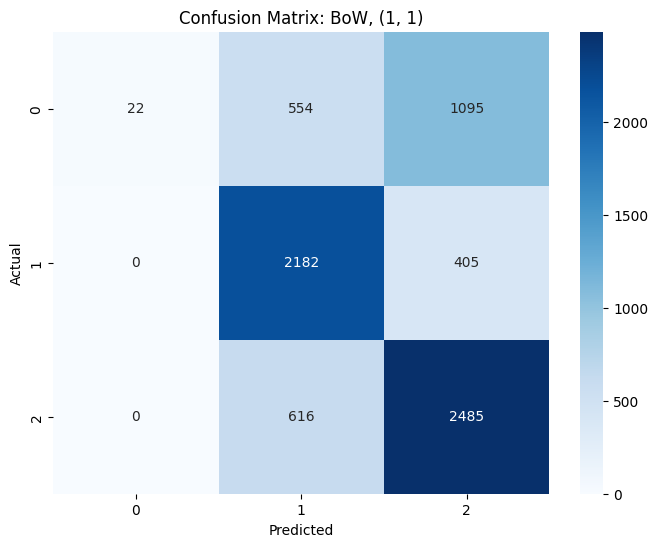

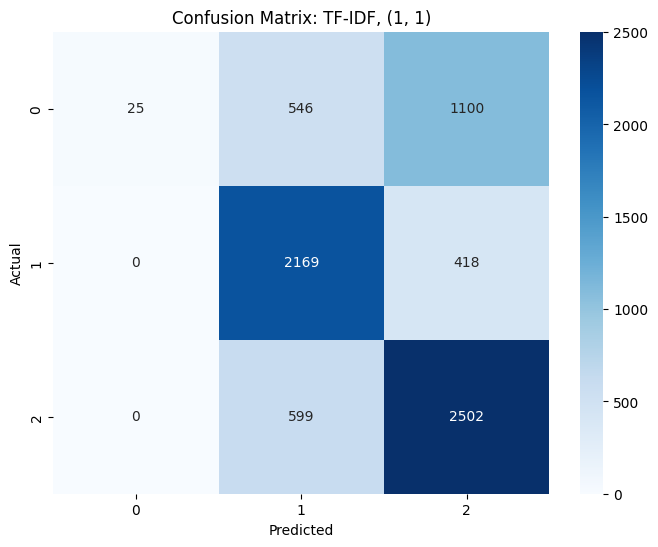

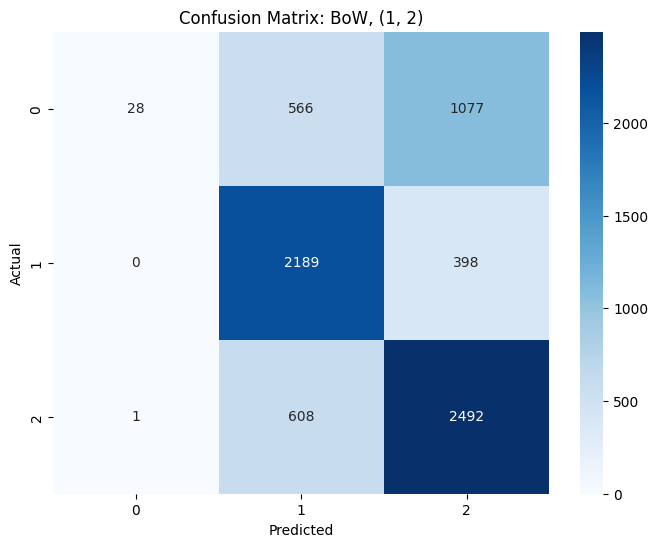

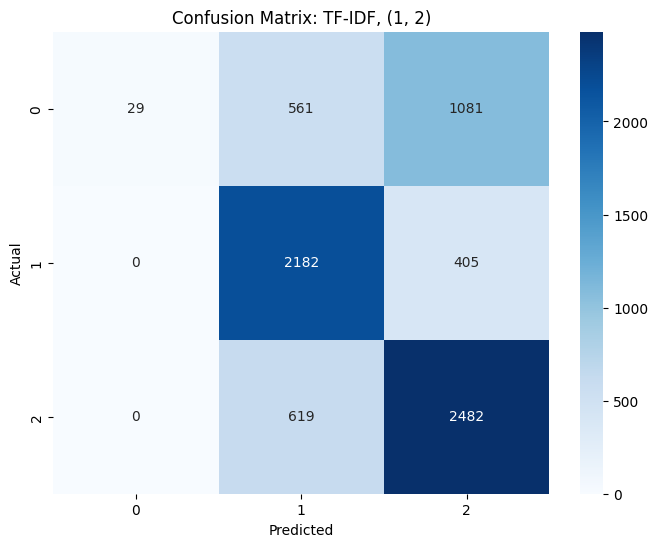

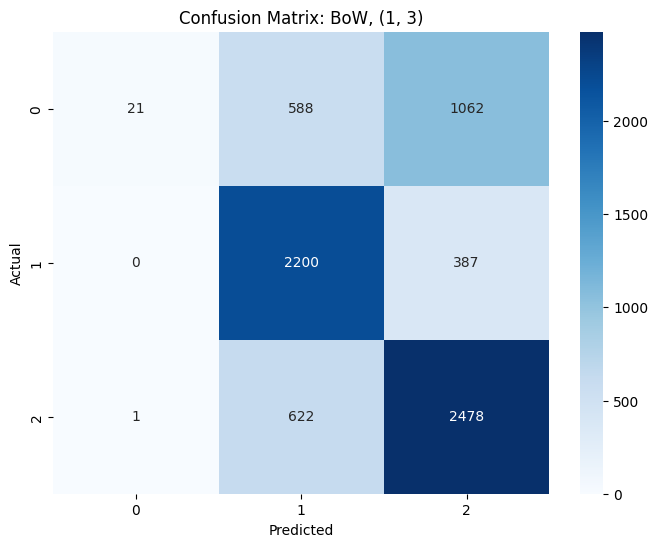

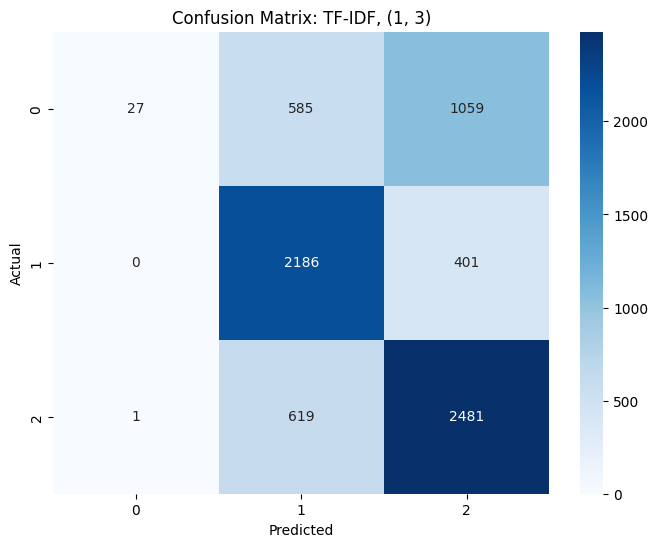

In [41]:
ngram_ranges = [(1,1),(1,2),(1,3)] # unigrams, bigrams, trigrams
max_features = 5000

for ngram_range in ngram_ranges :
  #BoW Experiments
  run_experiment("BoW",ngram_range,max_features,vectorizer_name="BoW")

  # TF-IDF experiments
  run_experiment("TF-IDF",ngram_range,max_features,vectorizer_name="TF-IDF")

